# TDM: Have a go!

#### Matteo Cancellieri and Lucas Anastasiou, CORE, Open University, United Kingdom

#### Mail: theteam@core.ac.uk
#### Twitter: @oacore @openminted_eu waiting for your questions!

https://github.com/oacore/collaboration_discovery_experiment

A few things you can do with out of the box TDM tools.
- Tokenizing text to sentences / words
- Filtering stopwords
- Stemming,Lemmatization, synonyms using WordNet
- Create a corpora
- POS tagging

And many many other we are not able to cover in this demo.

The tools we will use:

- Ntlk (http://www.nltk.org/)
- Dbpedia (http://wiki.dbpedia.org/)
- Matplotlib (https://matplotlib.org/)
- Textrazor (https://www.textrazor.com/)
- Pandas (http://pandas.pydata.org/)
- Wordcloud (https://github.com/amueller/word_cloud)

## Ready, set
To run python notebooks you would need a notebook server. The best way to install one locally is the anaconda distribution you can download and install (versions for windows, mac, linux):
https://www.continuum.io/downloads

After you install anaconda, run in the command line:
```
git clone https://github.com/oacore/collaboration_discovery_experiment.git
cd collaboration_discovery_experiment
jupyter notebook
```

A server will start on http://localhost:8888 showing all the available notebooks of the current folder.

Highly recommended:

Run create_cache python notebook to populate /data folder with cached data to be used for the main notebook (tdm demo). Only data files of repository 1 are included in this git repo (to avoid tracking of big (~10Mb) files)



## Go!

select the "tdm demo.ipynb" notebook and run it.



## Register your api key

Here: https://core.ac.uk/api-keys/register

It takes literally 2 min

.. and that if you are slow

Once you are done, put the key in the same directory of this Notebook in a file called ```api_key.secret```

## Explore the CORE API

https://core.ac.uk/services#api

Play with the live console (Swagger)

https://core.ac.uk/docs/

## A small CORE API client 

Nothing like a full CORE API client like the one for java that covers all the functionalities of CORE API (https://github.com/oacore/oacore4j). Yet, is a simple wrapper, essentially a class that crafts URLs and with the use of urllib fetches the content of that URL

#### Keep an eye in http://github.com/oacore more clients / modules / bundles for other programming languages coming up soon!

In [2]:
from urllib2 import urlopen
from urllib import urlencode
from urllib import quote_plus
from urllib import quote
# import urllib.parse
import json
import pprint

class CoreApiClient:

    def __init__(self, endpoint, api_key):
        self.endpoint = endpoint
        self.api_key = api_key
        #defaults
        self.pagesize = 100
        self.page = 1

    def parse_response(self, decoded):
        res = []
        for item in decoded['data']:
            doi = None
            if 'identifiers' in item:
                for identifier in item['identifiers']:
                    if identifier and identifier.startswith('doi:'):
                        doi = identifier
                        break
            res.append([item['title'], doi])
        return res

    def request_url(self, url):
        response = urlopen(url)
        html = response.read()
        return html

    def get_method_query_request_url(self,method,query,fullText,page):
        if (fullText):
            fullText = 'true'
        else:
            fullText = 'false'
        params = {
            'apiKey':self.api_key,
            'page':page,
            'pageSize':self.pagesize,
            'fulltext':fullText
        }
        return self.endpoint + method + '/' + quote_plus(query) + '?' + urlencode(params)

    def get_up_to_20_pages_of_query(self,method,query,fulltext):
        url = self.get_method_query_request_url(method,query,fulltext,1)
        all_articles=[]
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        all_articles.append(result)
        if (result['totalHits']>100):
            numOfPages = int(result['totalHits']/self.pagesize)  #rounds down
            if (numOfPages>20):
                numOfPages=20
            for i in range(2,numOfPages):
                url = self.get_method_query_request_url(method,query,False,i)
                print(url)
                resp =self.request_url(url)
                all_articles.append(json.loads(resp.decode('utf-8')))
        return all_articles
    
    def get_repository_articles_fulltext_as_dict(self,repository_id):
        return ""
    
    def get_search_repository_request_url(self,repoQuery,page=1,pageSize=10):
        params={
            'apiKey':self.api_key,
            'page':page,
            'pageSize':pageSize
        }
        return self.endpoint + "/repositories/search/"+quote_plus(repoQuery)+'?'+urlencode(params)
    
    def search_repository_ids_by_name(self,repoName):
        discoverRepoUrl = self.get_search_repository_request_url(repoName)
        resp = self.request_url(discoverRepoUrl)
        result = json.loads(resp.decode('utf-8'))
        for item in result['data']:
            if 'name' in item:
                name = item['name']
            if 'id' in item:
                id = item['id']
            repos[id]=name
        return repos
    
    def get_count_articles_of_repository_url(self,repoId,withFullText):
        ft = 'false'
        if(withFullText):
            ft = 'true'
                
        params = {
            'apiKey':self.api_key,
            'fulltext':ft
        }    
        return self.endpoint + "/articles/search/repositories.id:"+repoId+'?'+urlencode(params)
    
    def count_articles_of_repository(self,repoId,withFullText=False):
        countArticlesOfRepoUrl = self.get_count_articles_of_repository_url(repoId,withFullText)
        print(countArticlesOfRepoUrl)
        resp = self.request_url(countArticlesOfRepoUrl)
        result = json.loads(resp.decode('utf-8'))
        return result['totalHits']
    
    def get_url_of_download_articles_of_repository(self,repoId,fullText,page,pageSize):
        params={
            'apiKey':self.api_key,
            'page':page,
            'pageSize':pageSize,
            'fulltext':fullText
               }
        return self.endpoint + "/articles/search/repositories.id:"+str(repoId)+'?'+urlencode(params)
    
    def download_articles_of_repository(self, repoId, fulltext=True, page=1, pageSize=100):
        url = self.get_url_of_download_articles_of_repository(repoId,fulltext,page,pageSize)
        all_articles=[]
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['totalHits']>100):
            numOfPages = int(result['totalHits']/self.pagesize)  #rounds down
            if (numOfPages>5):
                numOfPages=5
            for i in range(2,numOfPages):
                url = self.get_url_of_download_articles_of_repository(repoId,fulltext,page,pageSize)
                print(url)
                resp =self.request_url(url)
                all_articles.append(json.loads(resp.decode('utf-8')))
        return all_articles
    
    def get_core_article_by_id(self,core_id,fulltext=False):
        ft='false'
        if (fulltext):
            ft='true'
        params={
            'apiKey':self.api_key,
            'fulltext':ft
        }
        url = self.endpoint + '/articles/get/'+str(core_id)+'?'+urlencode(params)
        print(url)
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['data']):
            return result['data']
        else:
            return ""
        return ""
    
    def get_core_article_by_doi(self,doi,fulltext=False):
        ft='false'
        if (fulltext):
            ft='true'
        query = "\""+doi+"\""
        params={
            'apiKey':self.api_key,
            'fulltext':ft
        }
        url = self.endpoint + '/articles/search/doi:'+quote(query)+'?'+urlencode(params)
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['totalHits']>=1):
            return result['data'][0]
        else:
            return ""
        

### Setup the CORE API Client

In [3]:
'''
Initialise parameters
'''
# init 
endpoint = 'https://core.ac.uk/api-v2'

'''
********************************************
Add your own api key below
'''
api_key =""
# or get it from a config file
file = open("api_key.secret","r") 
api_key=file.read()
api_key=api_key.strip()
'''
********************************************
'''
'''
Create your api object
'''
api = CoreApiClient(endpoint,api_key)


In [4]:
'''
Fetch an article by DOI
'''

doi="10.1016/j.nuclphysb.2015.11.012"
print(api.get_core_article_by_doi(doi,True))

{u'fullText': u'a\nr\nX\ni\nv\n:\n1\n0\n0\n7\n.\n1\n7\n7\n0\nv\n1\n \n \n[\nh\ne\np\n-\nt\nh\n]\n \n \n1\n1\n \nJ\nu\nl\n \n2\n0\n1\n0\nPreprint typeset in JHEP style - HYPER VERSION LPT ENS-10/25\nFinite Size Spectrum of SU(N) Principal Chiral Field\nfrom Discrete Hirota Dynamics\nVladimir Kazakov\u2217 and S\xb4 ebastien Leurent\nEcole Normale Superieure, LPT, 75231 Paris CEDEX-5, France &\nl\u2019Universit\xb4 e Paris-VI, Paris, France;\nE-mail: Vladimir.Kazakov\u2022ens.fr, Sebastien.Leurent\u2022ens.fr\nAbstract: Using recently proposed method of discrete Hirota dynamics for integrable\n(1+1)D quantum \ufb01eld theories on a \ufb01nite space circle of length L we derive and test\nnumerically a \ufb01nite system of nonlinear integral equations for the exact spectrum of energies\nof SU(N) \xd7 SU(N) principal chiral \ufb01eld model as functions of mL, where m is the mass\nscale. We propose a determinant solution of the underlying Y-system, or Hirota equation,\nin terms of determinan

In [5]:
'''
Fetch an article by core ID
'''
id=42
#just metadata
api.get_core_article_by_id(id)

https://core.ac.uk/api-v2/articles/get/42?fulltext=false&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX


{u'authors': [u'Bell, Simon', u'Christina, Ann'],
 u'contributors': [],
 u'datePublished': u'2006-02',
 u'description': u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward',
 u'fulltextIdentifier': u'https://core.ac.uk/download/pdf/42.pdf',
 u'id': u'42',
 u'identifiers': [u'oai:open.ac.uk.OAI2:108', None],
 u'language': {u'code': u'en', u'id': 9, u'name': u'English'},
 u'oai': u'oai:open.ac.uk.OAI2:

In [6]:
#with full text
api.get_core_article_by_id(id,True)

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX


{u'authors': [u'Bell, Simon', u'Christina, Ann'],
 u'contributors': [],
 u'datePublished': u'2006-02',
 u'description': u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward',
 u'fullText': u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Articl

# Time for some NLP!

NLTK (Natural Language Toolkit - http://www.nltk.org/) swiss army knife for NLP tasks in Python.

In [7]:
'''
In case you don't have nltk - uncomment and run
'''
#!pip install nltk
#import nltk
#nltk.download()

import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/mc26486/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
'''
in case any of the below complains, you need to download the corresponding corpora by executing:
nltk.download()
'''
from nltk.probability import FreqDist
from nltk.corpus import treebank



#### We start by analysing an article with full text from CORE. (https://core.ac.uk/display/42)

In [9]:
articleText = api.get_core_article_by_id(42,True)['fullText']
articleText

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX


u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006). Applying Systemic Project Management Approaches for the\nUK National Health Service. Systemic Practice and Action Research, 19(1), pp. 27\u201343.\nFor guidance on citations see FAQs.\nc\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners. For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.\noro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr. Simon Bell Ann Christina \nOpen 

## Sentence segmentation

> *Sentence segmentation* is the problem of dividing a string of written language into its component sentences. (from Wikipedia) 

In [10]:
'''
Let's split the text into sentences:
'''
sentences = nltk.sent_tokenize(articleText)
sentences

[u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).',
 u'Applying Systemic Project Management Approaches for the\nUK National Health Service.',
 u'Systemic Practice and Action Research, 19(1), pp.',
 u'27\u201343.',
 u'For guidance on citations see FAQs.',
 u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners.',
 u'For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.',
 u'oro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr.


> *Couldn't we just split with punctuation (such as ".")? Well...


In [11]:
wrong_sentences = articleText.split(".")
len(wrong_sentences)

396

In [30]:
len(sentences)

327

In [31]:
'''
Apparently not, e.g. see this sentence
'''
print (sentences[5])

c© [not recorded]
Version: [not recorded]
Link(s) to article on publisher’s website:
http://dx.doi.org/doi:10.1007/s11213-005-9002-4
Copyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-
right owners.


In [32]:
print (sentences[5].split("."))

[u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx', u'doi', u'org/doi:10', u'1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners', u'']


It incorrectly breaks down to more than one (5) sentences.

#### Let's break down in tokens (words)

In [33]:
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
tokenized_sentences[1:50]

[[u'Applying',
  u'Systemic',
  u'Project',
  u'Management',
  u'Approaches',
  u'for',
  u'the',
  u'UK',
  u'National',
  u'Health',
  u'Service',
  u'.'],
 [u'Systemic',
  u'Practice',
  u'and',
  u'Action',
  u'Research',
  u',',
  u'19',
  u'(',
  u'1',
  u')',
  u',',
  u'pp',
  u'.'],
 [u'27\u201343', u'.'],
 [u'For', u'guidance', u'on', u'citations', u'see', u'FAQs', u'.'],
 [u'c\xa9',
  u'[',
  u'not',
  u'recorded',
  u']',
  u'Version',
  u':',
  u'[',
  u'not',
  u'recorded',
  u']',
  u'Link',
  u'(',
  u's',
  u')',
  u'to',
  u'article',
  u'on',
  u'publisher',
  u'\u2019',
  u's',
  u'website',
  u':',
  u'http',
  u':',
  u'//dx.doi.org/doi:10.1007/s11213-005-9002-4',
  u'Copyright',
  u'and',
  u'Moral',
  u'Rights',
  u'for',
  u'the',
  u'articles',
  u'on',
  u'this',
  u'site',
  u'are',
  u'retained',
  u'by',
  u'the',
  u'individual',
  u'authors',
  u'and/or',
  u'other',
  u'copy-',
  u'right',
  u'owners',
  u'.'],
 [u'For',
  u'more',
  u'information',
  u

## Part of speech tagging (POS tagging):

>...is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech, based on both its definition and its context—i.e., its relationship with adjacent and related words in a phrase, sentence, or paragraph. (from Wikipedia)

Words are extracted and marked with:

- NN -> noun (plural)
- NNP -> noun (singular)
- VB -> Verb
- CC -> conjuction
... (more at http://www.comp.leeds.ac.uk/amalgam/tagsets/upenn.html)

In [34]:
pos_tagged_0 = nltk.pos_tag(tokenized_sentences[0])
pprint.pprint(sentences[0])
pprint.pprint(tokenized_sentences[0])
pprint.pprint(pos_tagged_0)

u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).'
[u'Open',
 u'Research',
 u'Online',
 u'The',
 u'Open',
 u'University',
 u'\u2019',
 u's',
 u'repository',
 u'of',
 u'research',
 u'publications',
 u'and',
 u'other',
 u'research',
 u'outputs',
 u'Applying',
 u'Systemic',
 u'Project',
 u'Management',
 u'Approaches',
 u'for',
 u'the',
 u'UK',
 u'National',
 u'Health',
 u'Service',
 u'Journal',
 u'Article',
 u'How',
 u'to',
 u'cite',
 u':',
 u'Bell',
 u',',
 u'Simon',
 u'and',
 u'Christina',
 u',',
 u'Ann',
 u'(',
 u'2006',
 u')',
 u'.']
[(u'Open', 'JJ'),
 (u'Research', 'NNP'),
 (u'Online', 'NNP'),
 (u'The', 'DT'),
 (u'Open', 'NNP'),
 (u'University', 'NNP'),
 (u'\u2019', 'NNP'),
 (u's', 'VBD'),
 (u'repository', 'NN'),
 (u'of', 'IN'),
 (u'research', 'NN'),
 (u'publications

## NER Named Entity Recognition
>... locate and classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. (from Wikipedia)


In [35]:
parse_tree = nltk.ne_chunk(nltk.tag.pos_tag(sentences[1].split()), binary=True)
named_entities = []

for t in parse_tree.subtrees():
    if t.label() == 'NE':
#        named_entities.append(t)
        named_entities.append(list(t))  # if you want to save a list of tagged words instead of a tree

(sentences[1], named_entities)

(u'Applying Systemic Project Management Approaches for the\nUK National Health Service.',
 [[(u'Systemic', 'NNP'), (u'Project', 'NNP')],
  [(u'UK', 'NNP'), (u'National', 'NNP'), (u'Health', 'NNP')]])

## Improving the Named Entity recognition: DBPedia spotlight
A REST API service to annotate with semantic informations your texts
https://github.com/dbpedia-spotlight/dbpedia-spotlight/wiki

In [36]:
## DBPedia spotlight:
'''
Get the article abstract
'''
articleAbstract=api.get_core_article_by_id(42,True)['description']
print(articleAbstract)

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX
This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward


In [37]:
url = "http://model.dbpedia-spotlight.org/en/annotate?text="+quote_plus(articleAbstract)
response = urlopen(url)
r_text = response.read()
from IPython.core.display import HTML
HTML(r_text)

## Text razor

#### Paid API (with a free tier), returns freebase entities and also a confidence score of the prediction. https://www.textrazor.com/


In [38]:
'''if not installed uncomment this line'''
# !pip install textrazor
import textrazor

In [39]:
#personal API key - just for this demo - please do not use anywhere else
textrazor.api_key = "eba9d80209aaad9627277d21437d2e0f56ef9c1e6e16332f221af063"

client = textrazor.TextRazor(extractors=["entities", "topics"])
response = client.analyze(articleAbstract)


for entity in response.entities()[1:2]:
    print entity.id, entity.relevance_score, entity.confidence_score
    print (entity.freebase_types)

Shropshire 0.2014 4.447
[u'/location/uk_statistical_location', u'/business/employer', u'/location/dated_location', u'/location/administrative_division', u'/location/uk_non_metropolitan_county', u'/location/location', u'/location/statistical_region', u'/location/uk_unitary_authority']


## Stemming
> is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form (from Wikipedia).

In [40]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [41]:
stemmer.stem("Management")


u'manag'

In [42]:
stemmer.stem("Manager")

u'manag'

In [43]:
stemmer.stem("Managerial")

u'manageri'

In [44]:
for token in tokenized_sentences[0]:
    print({"Original": token,"STEM": stemmer.stem(token)})

{'Original': u'Open', 'STEM': u'open'}
{'Original': u'Research', 'STEM': u'research'}
{'Original': u'Online', 'STEM': u'onlin'}
{'Original': u'The', 'STEM': u'the'}
{'Original': u'Open', 'STEM': u'open'}
{'Original': u'University', 'STEM': u'univers'}
{'Original': u'\u2019', 'STEM': u'\u2019'}
{'Original': u's', 'STEM': u's'}
{'Original': u'repository', 'STEM': u'repositori'}
{'Original': u'of', 'STEM': u'of'}
{'Original': u'research', 'STEM': u'research'}
{'Original': u'publications', 'STEM': u'public'}
{'Original': u'and', 'STEM': u'and'}
{'Original': u'other', 'STEM': u'other'}
{'Original': u'research', 'STEM': u'research'}
{'Original': u'outputs', 'STEM': u'output'}
{'Original': u'Applying', 'STEM': u'appli'}
{'Original': u'Systemic', 'STEM': u'system'}
{'Original': u'Project', 'STEM': u'project'}
{'Original': u'Management', 'STEM': u'manag'}
{'Original': u'Approaches', 'STEM': u'approach'}
{'Original': u'for', 'STEM': u'for'}
{'Original': u'the', 'STEM': u'the'}
{'Original': u'UK'

> *What if my texts are not in English?*

In [45]:
from nltk.stem import SnowballStemmer
SnowballStemmer.languages

(u'danish',
 u'dutch',
 u'english',
 u'finnish',
 u'french',
 u'german',
 u'hungarian',
 u'italian',
 u'norwegian',
 u'porter',
 u'portuguese',
 u'romanian',
 u'russian',
 u'spanish',
 u'swedish')

## Lemmatization

>the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form (from Wikipedia).

*Like stemming but not exactly - more like synonym replacement*

In [46]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('managerial')

'managerial'

In [47]:
lemmatizer.lemmatize('buses')

u'bus'

Pretty much the same, or maybe not ??

In [48]:
for token in tokenized_sentences[0]:
    print({"Original": token,"STEM": stemmer.stem(token)})



'''printing all the words that lemma is different than the word'''
for tokenized_sentence in tokenized_sentences:
    for token in tokenized_sentence:
        ltoken = lemmatizer.lemmatize(token)
        stoken=stemmer.stem(token)
        if (ltoken!=token):
            print({"Original": token,"STEM": stoken, "LEMMA":ltoken})


{'Original': u'Open', 'STEM': u'open'}
{'Original': u'Research', 'STEM': u'research'}
{'Original': u'Online', 'STEM': u'onlin'}
{'Original': u'The', 'STEM': u'the'}
{'Original': u'Open', 'STEM': u'open'}
{'Original': u'University', 'STEM': u'univers'}
{'Original': u'\u2019', 'STEM': u'\u2019'}
{'Original': u's', 'STEM': u's'}
{'Original': u'repository', 'STEM': u'repositori'}
{'Original': u'of', 'STEM': u'of'}
{'Original': u'research', 'STEM': u'research'}
{'Original': u'publications', 'STEM': u'public'}
{'Original': u'and', 'STEM': u'and'}
{'Original': u'other', 'STEM': u'other'}
{'Original': u'research', 'STEM': u'research'}
{'Original': u'outputs', 'STEM': u'output'}
{'Original': u'Applying', 'STEM': u'appli'}
{'Original': u'Systemic', 'STEM': u'system'}
{'Original': u'Project', 'STEM': u'project'}
{'Original': u'Management', 'STEM': u'manag'}
{'Original': u'Approaches', 'STEM': u'approach'}
{'Original': u'for', 'STEM': u'for'}
{'Original': u'the', 'STEM': u'the'}
{'Original': u'UK'

So is like stemming, or maybe not

## Spelling correction

##### can be done with import enchant but omitting for now

# Small text mining exercise

## Get and store some data from the CORE API

In [49]:
repoId=1
'''
Use page size 50 
-
store as pickle every 200 articles (4 pages)
in the end you will have in the /data folder files like: *
all_articles_on1_1.pkl
all_articles_on1_2.pkl
all_articles_on1_3.pkl
...


*/data is in .gitignore 
'''
import os
import pickle
if not os.path.exists('./data'):
    os.makedirs('./data')
all_articles=[]

for i in range(1,40):
    if not os.path.exists('./data/all_articles_on'+str(repoId)+'_'+str(i/4)+'.pkl'):
        url = api.get_url_of_download_articles_of_repository(repoId,True,i,50)# 40* 50 = 2000 (maximum articles per repo)
        response = urlopen(url)
        resp = response.read()
        result = json.loads(resp.decode('utf-8'))
        all_articles.append(result)
        if (i%4==0):
            pickle.dump(all_articles,open('data/all_articles_on'+str(repoId)+'_'+str(i/4)+'.pkl','wb'),pickle.HIGHEST_PROTOCOL)
            all_articles=[]

## What is a pickle? And what's inside it?


In [50]:
import pickle
try:
    articles = pickle.load(open('data/all_articles_on1_1.pkl','rb'))
except (OSError,IOError) as e:
    print(e)

In [51]:
articles[0]['data'][0]

{u'authors': [u'Burgin, L. V.', u'Edelsten, L.', u'Aspden, R. M.'],
 u'contributors': [u'University of Aberdeen, School of Medical Sciences',
  u'University of Aberdeen, Medicine, Medical Sciences & Nutrition, Division Applied Medicine'],
 u'datePublished': u'2014-02',
 u'description': u'Copyright \xa9 2013 IPEM. Published by Elsevier Ltd. All rights reserved.Peer reviewedPostprin',
 u'doi': u'10.1016/j.medengphy.2013.11.002',
 u'fullText': u"  \nThe mechanical and material properties of elderly human articular \ncartilage subject to impact and slow loading \n \nRunning title: Impact loading and composition of human cartilage \n \nL.V. Burgin1, L. Edelsten2 and R.M. Aspden* \nMusculoskeletal Research Programme, School of Medicine & Dentistry, University of \nAberdeen, Aberdeen, UK. \n1Current address: Medical Technologies Innovation and Knowledge Centre, X102 Medical \nand Biological Engineering - University of Leeds, Leeds, LS2 9JT. UK. \nL.V.Burgin@leeds.ac.uk \n2Current email addres

## Fun with words

In [52]:
### With frequency (tag clouds)
'''you might need to install these libraries'''
#!pip install simplejson
#!pip install pytagcloud
#!pip install pygame
#!pip install wordcloud

from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts

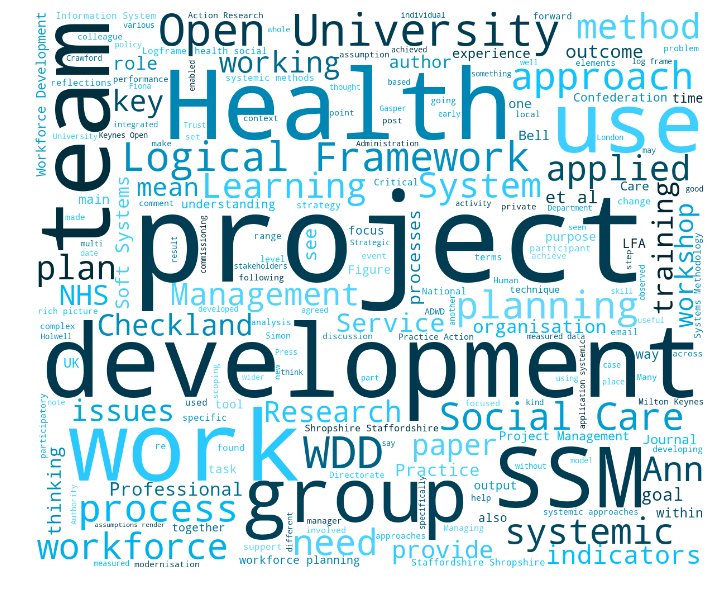

In [53]:
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

#Convert all the required text into a single string here 
#and store them in word_string

#you can specify fonts, stopwords, background color and other options

wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(articleText)

# store default colored image
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(195, 100%%, %d%%)" % random.randint(10, 70)
default_colors = wordcloud.to_array()

fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')

plt.show()

In [54]:
### With term frequency (tf-idf)
#removed to dev stuff/gensim.ipynb as it is unstable

## Discovering collaboration networks of a repository

In [55]:
text = articles[0]['data'][0]['fullText']

In [56]:
import re
match = re.findall(r'[\w\.-]+@[\w\.-]+', text)

In [57]:
match

[u'L.V.Burgin@leeds.ac.uk',
 u'Lorna.ramsay@education.gsi.gov.uk',
 u'r.aspden@abdn.ac.uk']

Now do the same for all the aricles of repository 1

In [58]:
import pickle 
import re
def get_all_emails_of_repository(repoId):
    all_emails = []
    for page_pickle in range(1,10):
        try:
            articles = pickle.load(open('data/all_articles_on'+str(repoId)+'_'+str(page_pickle)+'.pkl','rb'))
            for page in range(0,len(articles)):
                for item in articles[page]['data']:
                    text = item['fullText']
                    article_id=item['id']
                    match = re.findall(r'[\w\.-]+@[\w\.-]+', text)
#                     print(match)
                    all_emails.append([article_id, match])
        except (OSError,IOError) as e:
            print(e)
    return all_emails

In [59]:
emails_of_1 = get_all_emails_of_repository(1)

In [60]:
emails_of_1

[[u'19787393',
  [u'L.V.Burgin@leeds.ac.uk',
   u'Lorna.ramsay@education.gsi.gov.uk',
   u'r.aspden@abdn.ac.uk']],
 [u'19787406', [u'david.mcghee@abdn.ac.uk']],
 [u'20327925', [u'j.mercer@abdn.ac.uk', u'michelle.murphy@abdn.ac.uk']],
 [u'20664118', [u'Sarah.Harris@igmm.ed.ac.uk.']],
 [u'20664131', [u'T.Gillingwater@ed.ac.uk.']],
 [u'20664054', [u'jiabao.he@abdn.ac.uk']],
 [u'20664371', []],
 [u'19888921', [u's.schwarzkopf@gmail.com']],
 [u'20664053',
  [u'marie.castellazzi@hutton.ac.uk',
   u'diana.feliciano@abdn.ac.uk',
   u'iain.brown@hutton.ac.uk']],
 [u'20664046', [u'Jill.Francis.1@city.ac.uk']],
 [u'20664363', [u'jukka.corander@helsinki.fi', u's.k.sheppard@swansea.ac.uk']],
 [u'19787395', [u'a.price@abdn.ac.uk']],
 [u'20443919', []],
 [u'20443926', [u'a.r.akisanya@abdn.ac.uk.']],
 [u'19506505', [u'j.hussein@abdn.ac.uk']],
 [u'19888922', [u'c.hesse@abdn.ac.uk']],
 [u'19888923', [u'y.hopf@abdn.ac.uk']],
 [u'19506513', [u'clare.allely@glasgow.ac.uk']],
 [u'19506506', [u'n.r.velaga@ii

Let's flatten the list

In [61]:
def flatten_list(unevenList):
    flat_list=[]
    for sublist in unevenList:
        aid=sublist[0]
        emails = sublist[1]
        for item in emails:
            flat_list.append([aid,item])
    return flat_list
email_of_1_flat = flatten_list(emails_of_1)
len(email_of_1_flat)

2936

In [62]:
email_of_1_flat[1:10]

[[u'19787393', u'Lorna.ramsay@education.gsi.gov.uk'],
 [u'19787393', u'r.aspden@abdn.ac.uk'],
 [u'19787406', u'david.mcghee@abdn.ac.uk'],
 [u'20327925', u'j.mercer@abdn.ac.uk'],
 [u'20327925', u'michelle.murphy@abdn.ac.uk'],
 [u'20664118', u'Sarah.Harris@igmm.ed.ac.uk.'],
 [u'20664131', u'T.Gillingwater@ed.ac.uk.'],
 [u'20664054', u'jiabao.he@abdn.ac.uk'],
 [u'19888921', u's.schwarzkopf@gmail.com']]

In [63]:
#how many authors from aberdeen's articles are from aberdeen?
abdn_ctn=0
for i in email_of_1_flat:
    if i[1].endswith("abdn.ac.uk"):
        abdn_ctn +=1
print(abdn_ctn,len(email_of_1_flat))

(1132, 2936)



### so about 50% of authors in articles in the Aberdeen repository are not from Aberdeen

A really good tools for processing and query big quantities of data in python is pandas http://pandas.pydata.org/
The main data structures of Pandas are DataFrames.


Let's import a catalogue of all world domain of academic institutions and match it to authors, we can match the email domain with the institutions thanks to this dataset https://github.com/Hipo/university-domains-list

In [64]:
'''you might need to install it'''
# !pip install pandas
import pandas as pd



In [65]:
world_domains = pd.read_json('world_universities_and_domains.json')
world_domains.head()

,alpha_two_code,country,domain,name,web_page
0,US,United States,calbaptist.edu,California Baptist University,http://www.calbaptist.edu/
1,US,United States,stevenson.edu,Stevenson University,http://www.stevenson.edu/
2,US,United States,mbl.edu,Marine Biological Laboratory,http://www.mbl.edu/
3,US,United States,maryville.edu,Maryville University,http://www.maryville.edu/
4,US,United States,aii.edu,The Art Institutes,http://www.aii.edu/


In [66]:
#Create the frame with the emails

In [67]:
emails_df = pd.DataFrame.from_records(email_of_1_flat)
emails_df.head()

,0,1
0,19787393,L.V.Burgin@leeds.ac.uk
1,19787393,Lorna.ramsay@education.gsi.gov.uk
2,19787393,r.aspden@abdn.ac.uk
3,19787406,david.mcghee@abdn.ac.uk
4,20327925,j.mercer@abdn.ac.uk


We need to extract domain from each email:

In [68]:
def extract_domain(email):
    return email.split("@")[1]

In [69]:
#let's test:
extract_domain("mackenzie@abdn.ac.uk")

'abdn.ac.uk'

In [70]:
#now run it on all the frame
emails_df['domain']=emails_df.apply(lambda row: extract_domain(row[1]),axis=1)
emails_df.head()

,0,1,domain
0,19787393,L.V.Burgin@leeds.ac.uk,leeds.ac.uk
1,19787393,Lorna.ramsay@education.gsi.gov.uk,education.gsi.gov.uk
2,19787393,r.aspden@abdn.ac.uk,abdn.ac.uk
3,19787406,david.mcghee@abdn.ac.uk,abdn.ac.uk
4,20327925,j.mercer@abdn.ac.uk,abdn.ac.uk


Now for the extracted domain match it (join operation) with the known affiliation of this domain using our first frame

In [71]:
merged_domains = pd.merge(emails_df,world_domains , left_on='domain',right_on="domain")
merged_domains.head(10)

,0,1,domain,alpha_two_code,country,name,web_page
0,19787393,L.V.Burgin@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
1,18498901,T.R.A.Ensor@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
2,18498901,T.R.A.Ensor@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
3,17201917,n.alwan@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
4,177081,j.d.walley@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
5,30435804,r.m.wilkie@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
6,77052240,d.miller@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
7,77614526,pscplab@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
8,77614646,s.r.kingsbury@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
9,30435935,d.g.jayne@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/


In [72]:

merged_domains.columns = ['core_id', 'mail', 'domain','alpha_two_code', 'country', "name", "web"]


In [73]:
unique_domains = merged_domains.domain.unique()
unique_domains
domain_id_dict = {}
for domain in unique_domains:
    ids = merged_domains[merged_domains.domain==domain].core_id
    collaboration = merged_domains[merged_domains.core_id.isin(ids)].domain
    domain_id_dict[domain]=collaboration.values




#### And now let's group by to find biggest instituions collaborating with Aberdeen:

In [75]:
# merged_domains.groupby(['domain']).agg(['count']).reset_index('count').sort_values(['count'], ascending=False)
count_frame = merged_domains.groupby(['domain']).count().sort_values(['mail'],ascending=False)#.reset_index('count').sort_values(['count'], ascending=False)
count_frame.head(10)

,core_id,mail,alpha_two_code,country,name,web
domain,,,,,,
abdn.ac.uk,1111,1111,1111,1111,1111,1111
ncl.ac.uk,66,66,66,66,66,66
ed.ac.uk,52,52,52,52,52,52
dundee.ac.uk,19,19,19,19,19,19
lshtm.ac.uk,17,17,17,17,17,17
ucl.ac.uk,14,14,14,14,14,14
kcl.ac.uk,13,13,13,13,13,13
cam.ac.uk,12,12,12,12,12,12
bham.ac.uk,10,10,10,10,10,10


In [76]:
# count_frame = count_frame.ix[:,0:1]
# count_frame['ddomain'] = count_frame.index
# count_frame.head(10)
print(count_frame.index)

Index([u'abdn.ac.uk', u'ncl.ac.uk', u'ed.ac.uk', u'dundee.ac.uk',
       u'lshtm.ac.uk', u'ucl.ac.uk', u'kcl.ac.uk', u'cam.ac.uk', u'bham.ac.uk',
       u'leeds.ac.uk',
       ...
       u'tongji.edu.cn', u'le.ac.uk', u'adelaide.edu.au', u'uchile.cl',
       u'ucd.ie', u'ucalgary.ca', u'uah.es', u'ua.pt', u'tum.de',
       u'queensu.ca'],
      dtype='object', name=u'domain', length=153)


## External author-collaborators over time

In [77]:
import pickle 
import re
def get_all_emails_with_time_of_repository(repoId):
    all_emails = []
    for page_pickle in range(1,10):
        try:
            articles = pickle.load(open('data/all_articles_on'+str(repoId)+'_'+str(page_pickle)+'.pkl','rb'))
            for page in range(0,len(articles)):
                for item in articles[page]['data']:
                    text = item['fullText']
                    article_id=item['id']
                    year=item['year']
                    match = re.findall(r'[\w\.-]+@[\w\.-]+', text)
#                     print(match)
                    all_emails.append([article_id, year,match])
        except (OSError,IOError) as e:
            print(e)
    return all_emails

In [78]:
def flatten_list(unevenList):
    flat_list=[]
    for sublist in unevenList:
        aid=sublist[0]
        y=sublist[1]
        emails = sublist[2]
        for item in emails:
            flat_list.append([aid,y,item])
    return flat_list

In [79]:
aberdeen_emails_with_years= get_all_emails_with_time_of_repository(1)

In [80]:
aberdeen_emails_with_years_flatten=flatten_list(aberdeen_emails_with_years)

In [81]:
aberdeen_df = pd.DataFrame.from_records(aberdeen_emails_with_years_flatten)
aberdeen_df.head()

,0,1,2
0,19787393,2014,L.V.Burgin@leeds.ac.uk
1,19787393,2014,Lorna.ramsay@education.gsi.gov.uk
2,19787393,2014,r.aspden@abdn.ac.uk
3,19787406,2014,david.mcghee@abdn.ac.uk
4,20327925,2014,j.mercer@abdn.ac.uk


In [82]:
aberdeen_df['domain']=aberdeen_df.apply(lambda row: extract_domain(row[2]),axis=1)
aberdeen_df.head()

,0,1,2,domain
0,19787393,2014,L.V.Burgin@leeds.ac.uk,leeds.ac.uk
1,19787393,2014,Lorna.ramsay@education.gsi.gov.uk,education.gsi.gov.uk
2,19787393,2014,r.aspden@abdn.ac.uk,abdn.ac.uk
3,19787406,2014,david.mcghee@abdn.ac.uk,abdn.ac.uk
4,20327925,2014,j.mercer@abdn.ac.uk,abdn.ac.uk


In [83]:
aberdeen_df.columns = ["articleId","year","author_email","author_domain"]
aberdeen_df['external']=aberdeen_df['author_domain']!='abdn.ac.uk'

aberdeen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 5 columns):
articleId        2936 non-null object
year             2936 non-null int64
author_email     2936 non-null object
author_domain    2936 non-null object
external         2936 non-null bool
dtypes: bool(1), int64(1), object(3)
memory usage: 94.7+ KB


In [84]:
# ab_gr_df = aberdeen_df.groupby(["year"]).count().sort(["year"],ascending=False)#.reset_index('count').sort_values(['count'], ascending=False)
ab_gr_df = aberdeen_df[aberdeen_df.external==True].groupby("year").articleId.count()
index_per_year = ab_gr_df.div(aberdeen_df[aberdeen_df.external==False].groupby("year").articleId.count())
index_per_year.pop(2001)
index_per_year.pop(2002)
index_per_year.pop(2003)

nan

## $external\_collaboration\_index = \frac{\# papers\_with\_external\_collaborations}{\# papers\_with\_only\_internal\_authors}$

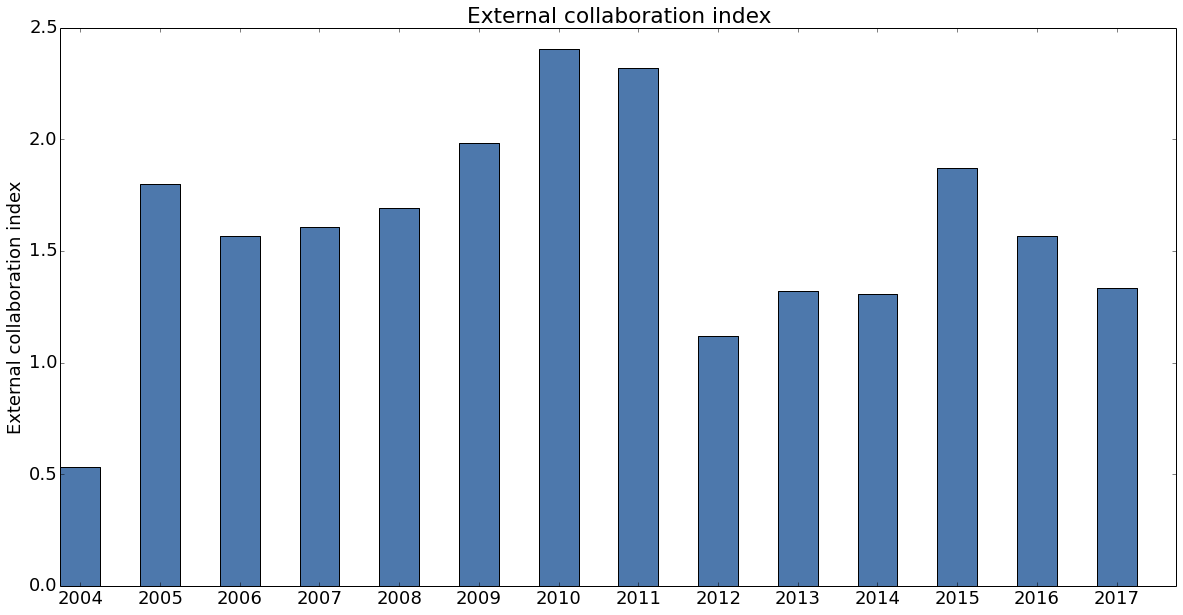

In [85]:
## external_collaboration_index bar chart
import numpy as np
import matplotlib.pyplot as plt

N = len(index_per_year)

ind = np.arange(N)  # the x locations for the groups
width = 0.50       # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, index_per_year, width, color='#4D78AC')

# add some text for labels, title and axes ticks
ax.set_ylabel('External collaboration index')
ax.set_title('External collaboration index')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(index_per_year.keys())

#ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))
plt.rcParams.update({'font.size': 18})
plt.show()


In [86]:
emails_of_repository=dict()
cached_repos=[1,86,39,136,48]
for i in cached_repos:
    emails_of_repository[i]=get_all_emails_of_repository(i)

In [87]:
emails_of_repository

{1: [[u'19787393',
   [u'L.V.Burgin@leeds.ac.uk',
    u'Lorna.ramsay@education.gsi.gov.uk',
    u'r.aspden@abdn.ac.uk']],
  [u'19787406', [u'david.mcghee@abdn.ac.uk']],
  [u'20327925', [u'j.mercer@abdn.ac.uk', u'michelle.murphy@abdn.ac.uk']],
  [u'20664118', [u'Sarah.Harris@igmm.ed.ac.uk.']],
  [u'20664131', [u'T.Gillingwater@ed.ac.uk.']],
  [u'20664054', [u'jiabao.he@abdn.ac.uk']],
  [u'20664371', []],
  [u'19888921', [u's.schwarzkopf@gmail.com']],
  [u'20664053',
   [u'marie.castellazzi@hutton.ac.uk',
    u'diana.feliciano@abdn.ac.uk',
    u'iain.brown@hutton.ac.uk']],
  [u'20664046', [u'Jill.Francis.1@city.ac.uk']],
  [u'20664363',
   [u'jukka.corander@helsinki.fi', u's.k.sheppard@swansea.ac.uk']],
  [u'19787395', [u'a.price@abdn.ac.uk']],
  [u'20443919', []],
  [u'20443926', [u'a.r.akisanya@abdn.ac.uk.']],
  [u'19506505', [u'j.hussein@abdn.ac.uk']],
  [u'19888922', [u'c.hesse@abdn.ac.uk']],
  [u'19888923', [u'y.hopf@abdn.ac.uk']],
  [u'19506513', [u'clare.allely@glasgow.ac.uk']],
 

In [88]:
## Combining important terms with external collaboration networks
### What are the topics that gets the most external authors ?

[None]

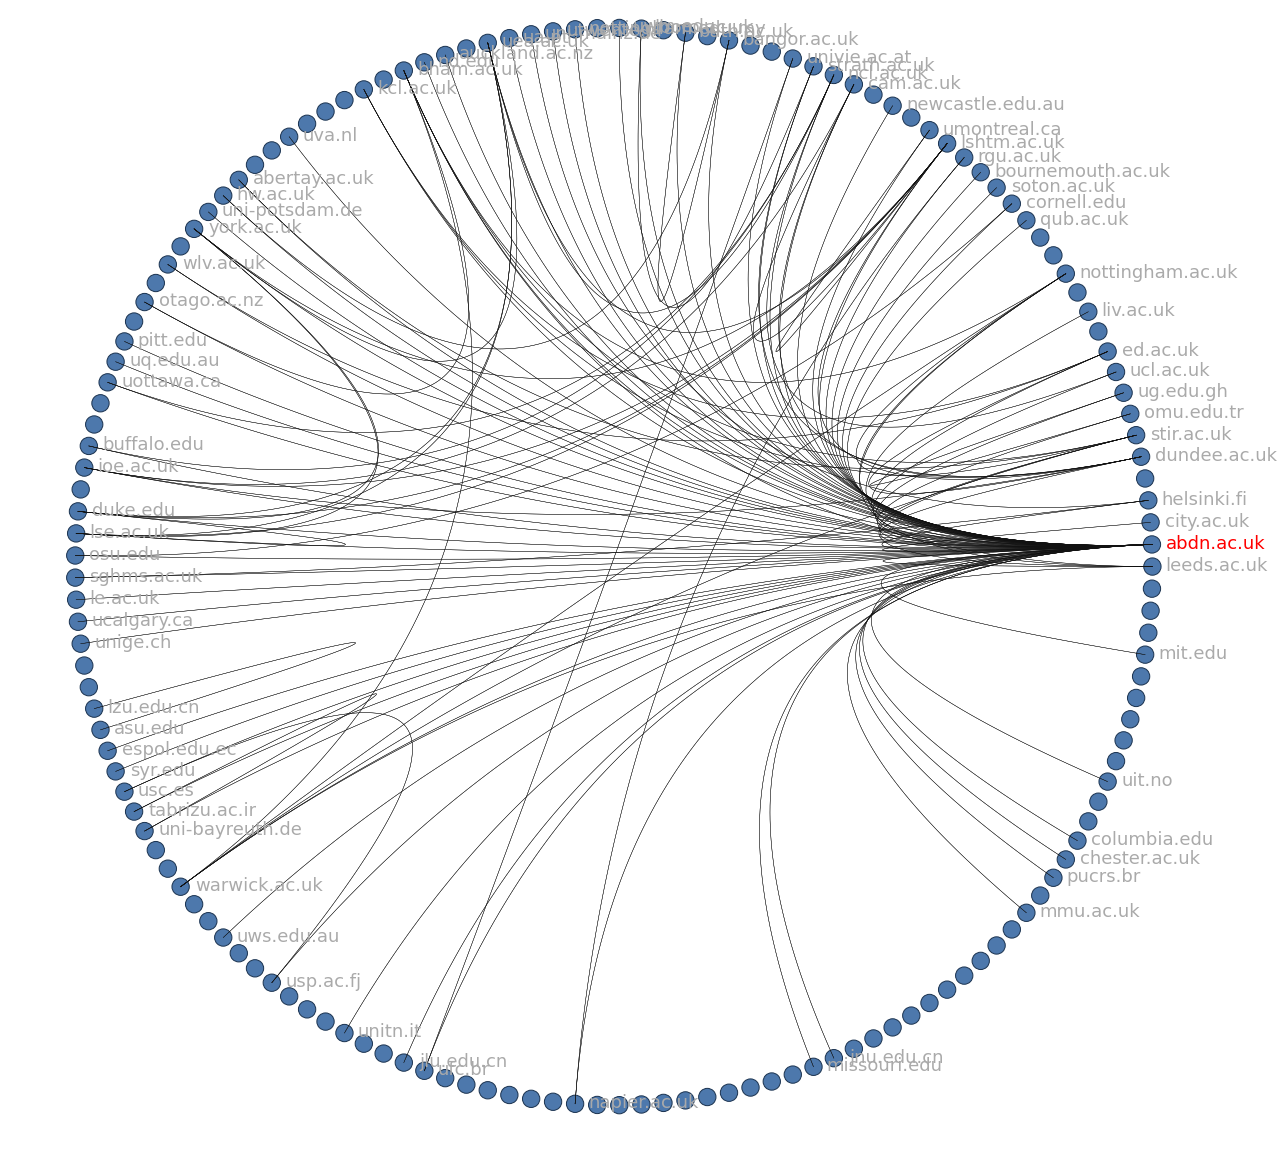

In [110]:
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import sys

domain_list= list(unique_domains)
fig, ax = plt.subplots(figsize=(30, 20))
plt.axis('off')

npoints = len(domain_list)

# Calculate the xy coords for each point on the circle
s = 2 * np.pi / npoints
verts = np.zeros((npoints, 2))
for i in np.arange(npoints):
    angle = s * i
    x = npoints * np.cos(angle)
    y = npoints * np.sin(angle)
    verts[i] = [x, y]
    

# Plot the Bezier curves
numbers = [i for i in xrange(npoints)]
bezier_path = np.arange(0, 1.01, 0.01)

x, y = verts.T
ax.scatter(x, y, marker='o', s=300, c='#4D78AC', edgecolor='#1D3552')
annotated =[]

for a,b in itertools.product(domain_list, repeat=2):
    if a == b:
        continue
       
    if a in domain_id_dict[b]:
       
        x1y1 = x1, y1 = verts[domain_list.index(a)]
        x2y2 = x2, y2 = verts[domain_list.index(b)]

        xbyb = xb, yb = [0, 0]

        # Compute and store the Bezier curve points
        x = (1 - bezier_path)** 2 * x1 + 2 * (1 - bezier_path) * bezier_path * xb + bezier_path** 2 * x2
        y = (1 - bezier_path)** 2 * y1 + 2 * (1 - bezier_path) * bezier_path * yb + bezier_path** 2 * y2
        ax.plot(x, y, 'k-', linewidth=0.4, c='#111111')
        
        if (a not in annotated):
            nodecolor= '#aaaaaa'
            if (a=="abdn.ac.uk"):
                nodecolor= 'red'
            ax.annotate(a, xy = verts[domain_list.index(a)], xytext = (+15, -4), textcoords = 'offset points', color=nodecolor)
            annotated.append(a)
        


ax.set_xlim(-npoints - 5, npoints + 6)
ax.set_ylim(-npoints - 5, npoints + 6)
ax.set(aspect=1)

In [106]:
from IPython.display import Image

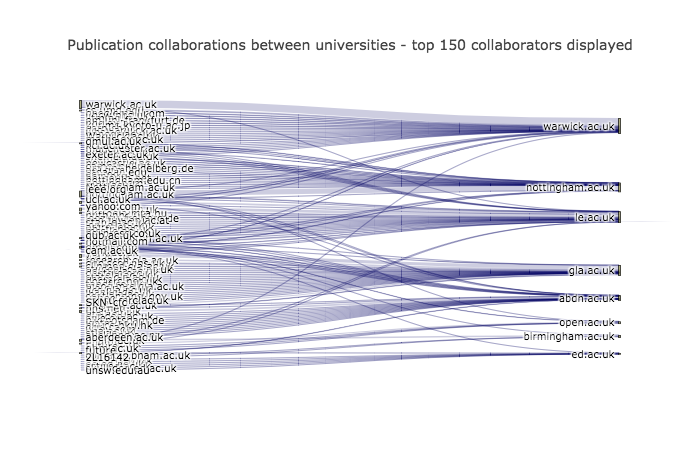

In [108]:
Image(filename='top300.png', width=1000)


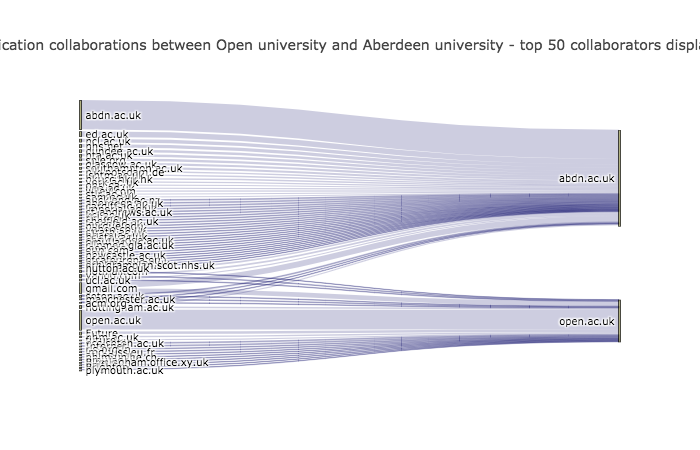

In [109]:
Image(filename='top50.png', width=1000)
